In [3]:
import torch
import torch.nn as nn

In [26]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        x = self.double_conv(x)
        return x

In [138]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder1 = DoubleConv(in_channels=in_channels, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = DoubleConv(in_channels=64, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = DoubleConv(in_channels=128, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = DoubleConv(in_channels=256, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(
            512,
            1024
        )

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(in_channels=1024, out_channels=512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(in_channels=512, out_channels=256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(in_channels=256, out_channels=128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(in_channels=128, out_channels=64)

        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([enc4, dec4], dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([enc3, dec3], dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([enc2, dec2], dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([enc1, dec1], dim=1)
        dec1 = self.decoder1(dec1)

        out = self.outconv(dec1)

        return out

In [181]:
model = UNet(in_channels=4, out_channels=4)

model

UNet(
  (encoder1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(in

(280, 390, 4)


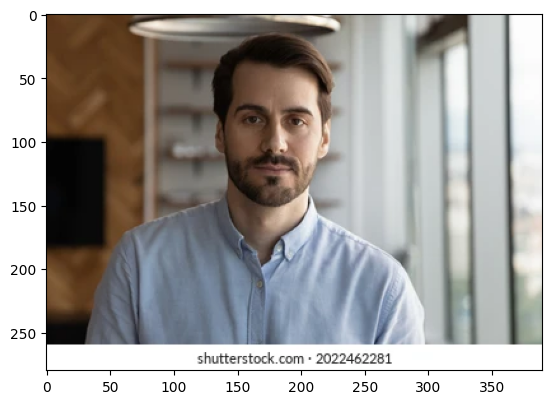

In [177]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img_rgb = Image.open('image2.png')
# img_rgb.convert('rgba')
np_img = np.array(img_rgb)

rgba = np.zeros((np_img.shape[0], np_img.shape[1], 4), dtype=np.uint8)
rgba[..., :3] = np_img
rgba[..., 3] = 255
print(rgba.shape)
img_rgba = Image.fromarray(rgba)
plt.imshow(img_rgba)


In [178]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

transformed = transform(img_rgba)




In [179]:
print(img_rgba.size)

(390, 280)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 128, 128, 4])


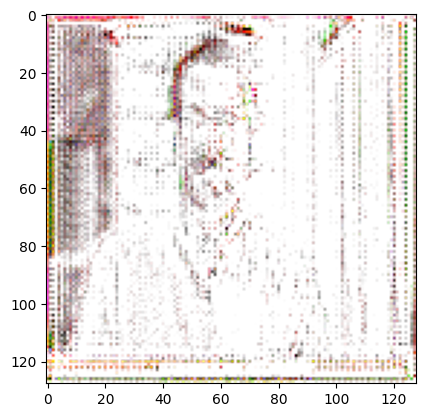

In [180]:



y = model(transformed.unsqueeze(0))

y = y.permute(0,2,3, 1)

print(y.shape)

plt.imshow(y[0].detach().numpy())